# Explore Dataset
In this project we are targeting to find correlation between a set of jobs, described by the job description and a group of candidates, described by their resume, so as to determine the worthiness in arranging an interview for the candidate for a particular job.

We did have a number of candidates of dataset as mentioned in the project proposal, but here are the two dataset we have finally selected for job descriptions and resumes:
- Online Job Postings – Armenian Online Job Posts from 2004 – 2015 (Hab, 2017) https://www.kaggle.com/madhab/jobposts
 - This dataset has 19000 online job posting on Armenian human resource portal, with 3759 IT jobs covering all areas.
 - The data is a bit dated but 50% of all IT jobs are after 2010
 - The average # of tokens for each post is around 300 which is suitable for BERT sentence pair classification (max 512)

- Resume Dataset from Avani Siddhapura (Siddhapura, 2020) https://www.kaggle.com/avanisiddhapura27/resume-dataset
 - This data set has 14800 IT related resumes with past job experiences, education records, certificates and skills parsed into separate sections and this is optimal for selecting target description for particular jobs title for labelling
 - All resumes in this dataset is from India which could create a bias in the training but that is common to all resume datasets available, so we will have to keep this in mind on result interpretation. As more relevant data is generated from a deployed system, the model can be retrained for data that conform to what the population is like for the particular company.

For data exploration, we are going to use LDA and BERT to see how well the data correlates to each other in the sentence vector space.

In [1]:
# spaCy-transformers only works with this version
!pip install transformers==2.8.0

In [2]:
import spacy
#spacy.require_gpu()
nlp = spacy.load('en_trf_bertbaseuncased_lg')
#nlp = spacy.load('/opt/conda/lib/python3.7/site-packages/en_trf_bertbaseuncased_lg/en_trf_bertbaseuncased_lg-2.3.0')
#nlp = spacy.load('/opt/conda/lib/python3.7/site-packages/en_trf_robertabase_lg/en_trf_robertabase_lg-2.3.0')

In [3]:
# These functions reads in the csv file and prints out sample and summary statistics for the dataset
import pandas as pd
import ast
from functools import partial
def convert_list(x, ast_off=False):
    #print(f"x = {x}")
    if type(x) != str:
        return x
    if len(x) != 0:
        if x[0] in ["{", "["] and x[-1] in ["}", "]"] and not ast_off:
            #print(f"String to be put in AST = {x}")
            try:
                return len(ast.literal_eval(x))
            except SyntaxError:
                #print(x)
                print("1 record corrupted")
                return 0
    return len(x)

def desc_df(path, encoding=None, xls=False, ast_off=False):
    print(path)
    if xls:
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path) if encoding is None else pd.read_csv(path, encoding)
    for col in df.columns:
        print(f"{col}:\n{df.iloc[0][f'{col}']}\n")
        print(df[f'{col}'].fillna(value="").map(partial(convert_list, ast_off=ast_off)).describe())
        print("\n----------------------------------------------------------------------------------")
    df.info()
    return df

In [4]:
# This is the Job posting dataset for the Armenian Job Center
armenian_job = desc_df("../data/job/armenian_data job posts.csv")
armenian_job

D:\PycharmProjects\ISMT-S117-project\data\job\armenian_data job posts.csv
jobpost:
AMERIA Investment Consulting Company
JOB TITLE:  Chief Financial Officer
POSITION LOCATION: Yerevan, Armenia
JOB DESCRIPTION:   AMERIA Investment Consulting Company is seeking a
Chief Financial Officer. This position manages the company's fiscal and
administrative functions, provides highly responsible and technically
complex staff assistance to the Executive Director. The work performed
requires a high level of technical proficiency in financial management
and investment management, as well as management, supervisory, and
administrative skills.
JOB RESPONSIBILITIES:  
- Supervises financial management and administrative staff, including
assigning responsibilities, reviewing employees' work processes and
products, counseling employees, giving performance evaluations, and
recommending disciplinary action;
- Serves as member of management team participating in both strategic
and operational planning for th

count    19001.000000
mean       219.551234
std        275.742062
min          0.000000
25%         79.000000
50%        150.000000
75%        279.000000
max       5353.000000
Name: JobDescription, dtype: float64

----------------------------------------------------------------------------------
JobRequirment:
- Supervises financial management and administrative staff, including
assigning responsibilities, reviewing employees' work processes and
products, counseling employees, giving performance evaluations, and
recommending disciplinary action;
- Serves as member of management team participating in both strategic
and operational planning for the company;
- Directs and oversees the company's financial management activities,
including establishing and monitoring internal controls, managing cash
and investments, and managing the investment portfolio in collaboration
with the Investment team leader. This includes, but is not limited to,
evaluation of investment risk, concentration risk, f

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18996,Technolinguistics NGO\r\n\r\n\r\nTITLE: Senio...,"Dec 28, 2015",Senior Creative UX/ UI Designer,Technolinguistics NGO,NaN,Full-time,NaN,NaN,NaN,Long-term,...,Competitive,"To apply for this position, please send your\r...",29 December 2015,28 January 2016,NaN,As a company Technolinguistics has a mandate t...,NaN,2015,12,False
18997,"""Coca-Cola Hellenic Bottling Company Armenia"" ...","Dec 30, 2015",Category Development Manager,"""Coca-Cola Hellenic Bottling Company Armenia"" ...",NaN,Full-time,All interested professionals.,NaN,ASAP,Long-term with a probation period of 3 months.,...,NaN,All interested candidates are kindly requested...,30 December 2015,20 January 2016,NaN,NaN,NaN,2015,12,False
18998,"""Coca-Cola Hellenic Bottling Company Armenia"" ...","Dec 30, 2015",Operational Marketing Manager,"""Coca-Cola Hellenic Bottling Company Armenia"" ...",NaN,Full-time,All interested professionals.,NaN,ASAP,Long-term with a probation period of 3 months.,...,NaN,All interested candidates are kindly requested...,30 December 2015,20 January 2016,NaN,NaN,NaN,2015,12,False
18999,San Lazzaro LLC\r\n\r\n\r\nTITLE: Head of O...,"Dec 30, 2015",Head of Online Sales Department,San Lazzaro LLC,NaN,NaN,NaN,NaN,NaN,Long-term,...,Highly competitive,Interested candidates can send their CVs to:\r...,30 December 2015,29 January 2016,NaN,San Lazzaro LLC works with several internation...,NaN,2015,12,False


In [5]:
# Here we get 50 jobs out of the IT related job descriptions, and mix with 25 non IT jobs, and embed them with SpaCy
import numpy as np
select_job = armenian_job[armenian_job.IT][armenian_job.Title.fillna("").str.lower().str.contains("developer|programmer|admin")][:50]
select_job = select_job.append(armenian_job[~armenian_job.IT][:25], ignore_index=True)
rep_desc = np.array([nlp(w).vector for w in select_job.jobpost])
rep_title = select_job.Title
rep_desc.shape, rep_title.shape, rep_title.value_counts()

D:\ProgramData\Anaconda3\envs\vec2rec-with-RoBERTa\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


((75, 768),
 (75,),
 Programmer                                                         8
 Software Developer                                                 4
 Network Administrator                                              3
 Web Designer/ Developer                                            2
 Web Programmer & Designer                                          2
 Web Programmer                                                     2
 Senior Java Developers                                             1
 Chief/ Supervisor of Programs Department                           1
 Java Programmer                                                    1
 Saleswoman                                                         1
 Program Assistant (INL), FSN-8; FP-6*                              1
 Country Economist (NOB)                                            1
 Country Coordinator                                                1
 System Administrator, Microsoft Web Developer, Microsoft Office    1


In [6]:
# Then we use t-SNE to reduce the dimension to 2D
from sklearn.manifold import TSNE
tsne_model_en_2d = TSNE(perplexity=7, n_components=2, init='pca', n_iter=5000, random_state=32)
tsne_out = tsne_model_en_2d.fit_transform(rep_desc)
print(tsne_model_en_2d.n_iter)
print(tsne_out[:5])
print(tsne_out.shape)

5000
[[ -753.074    -384.94138]
 [-2771.2815   -653.5402 ]
 [-3246.5312   -649.57965]
 [-1322.1432    220.10263]
 [ 2503.6646    -64.65103]]
(75, 2)


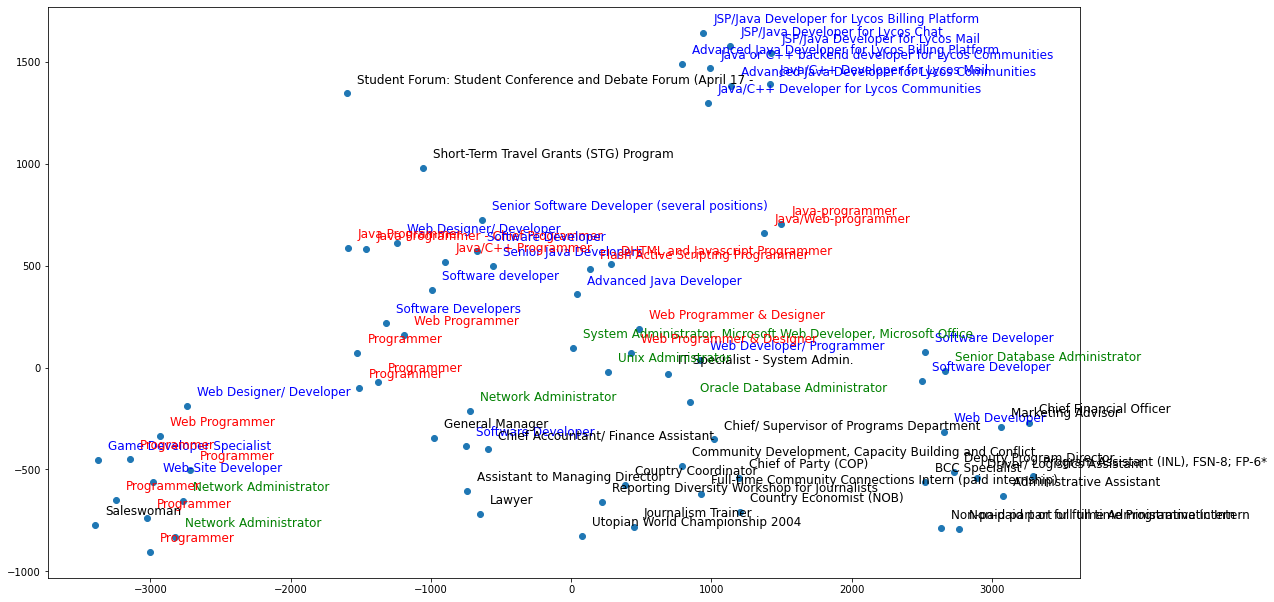

In [7]:
# Here we can see programmers and developers are really close and IT administrators are somewhere in between
# On the other hand, the non-IT tasks are generally clustered outside of the IT jobs, which shows good correlation
# in the corpus and suggesting that the transformer is a good match for the solution.
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(tsne_out[:,0], tsne_out[:,1])

for i, txt in enumerate(rep_title):
    color = "black"
    color = "red" if "programmer" in txt.lower() else color
    color = "blue" if "developer" in txt.lower() else color
    color = "green" if "administrator" in txt.lower() else color
    ax.annotate(txt, tsne_out[i], color=color, xytext=(10,10), textcoords='offset points', fontsize="12")

fig.set_size_inches(18.5, 10.5)

In [8]:
# As we see in 2.create_labels.ipynb, this is the Avani resume set, with the title and description of the past job
# experience session extracted. The Trash and Type columns are manually annotated to indicate which jobs are related to IT.
wdescr_df = pd.read_excel("../data/resumes/avani_resume_data.xlsx")
wdescr_df = wdescr_df[(wdescr_df.wtitle != "NONE") & (wdescr_df.wdescr != "NONE")].dropna(subset=["wtitle", "wdescr"])
wdescr_df

,Unnamed: 0,res_no,exp_no,wtitle,wdescr,Trash,Type,Word Count
1,1,1,0,JAVA DEVELOPER,Working as Software Developer at IngroInfo Sof...,NaN,Dev,49.0
3,3,3,0,Java Developer,• Working as a Java Developer at Atos Syntel. ...,NaN,Dev,34.0
4,4,4,0,Java Developer,• 2+ years' of experience in application of pa...,NaN,Dev,21.0
6,6,5,0,Java Developer,Have the potential to work with team as well a...,NaN,Dev,11.0
7,7,5,1,Java Developer,Have the potential to work with team as well a...,NaN,Dev,11.0
...,...,...,...,...,...,...,...,...
35530,35530,14802,1,Accountant,for the clients and the firm in Tally ERP \n• ...,Accountant,NaN,NaN
35531,35531,14802,2,Junior Accountant,• Updating Daily Banking Transactions in Sun S...,Accountant,NaN,NaN
35532,35532,14802,3,Accountant,• Posting Accounting Entries in Tally and Proc...,Accountant,NaN,NaN
35533,35533,14802,4,TAX CONSULTANT,- Asst.Staff \n \n• Preparation of Books of Ac...,tax,NaN,NaN


In [9]:
# Similar to above, here we select 20 description each for the 3 job types, and then add another 30 jobs for non IT jobs.
select_res = wdescr_df[~wdescr_df.Type.isna()][wdescr_df.wtitle.str.lower().str.contains("developer")][:20]
select_res = select_res.append(wdescr_df[~wdescr_df.Type.isna()][wdescr_df.wtitle.str.lower().str.contains("programmer")][:20], ignore_index=True)
select_res = select_res.append(wdescr_df[~wdescr_df.Type.isna()][wdescr_df.wtitle.str.lower().str.contains("admin")][:20], ignore_index=True)
select_res = select_res.append(wdescr_df[wdescr_df.Type.isna()][30:60], ignore_index=True)
rep_desc_res = np.array([nlp(w).vector for w in select_res.wdescr])
rep_title_res = select_res.wtitle
rep_desc_res.shape, rep_title_res.shape, rep_title_res.value_counts()

D:\ProgramData\Anaconda3\envs\vec2rec-with-RoBERTa\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
D:\ProgramData\Anaconda3\envs\vec2rec-with-RoBERTa\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\envs\vec2rec-with-RoBERTa\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


((90, 768),
 (90,),
 Java Developer                                            15
 C                                                          3
 Sr. PHP Programmer                                         3
 Programmer Analyst Trainee                                 2
 Software Developer, Database Administrator, Designer       2
                                                           ..
 Fashion consultant                                         1
 Asst. System/Network Administrator                         1
 NSS co-ordinator in national service scheme at DYPSOEA     1
 Cashier and Trainer                                        1
 C C A                                                      1
 Name: wtitle, Length: 65, dtype: int64)

5000
[[ -214.05699    -276.19583  ]
 [-1133.9899      146.07318  ]
 [-1401.8539        2.6237822]
 [-2537.503       337.24066  ]
 [-2548.5056      456.74506  ]]
(90, 2)


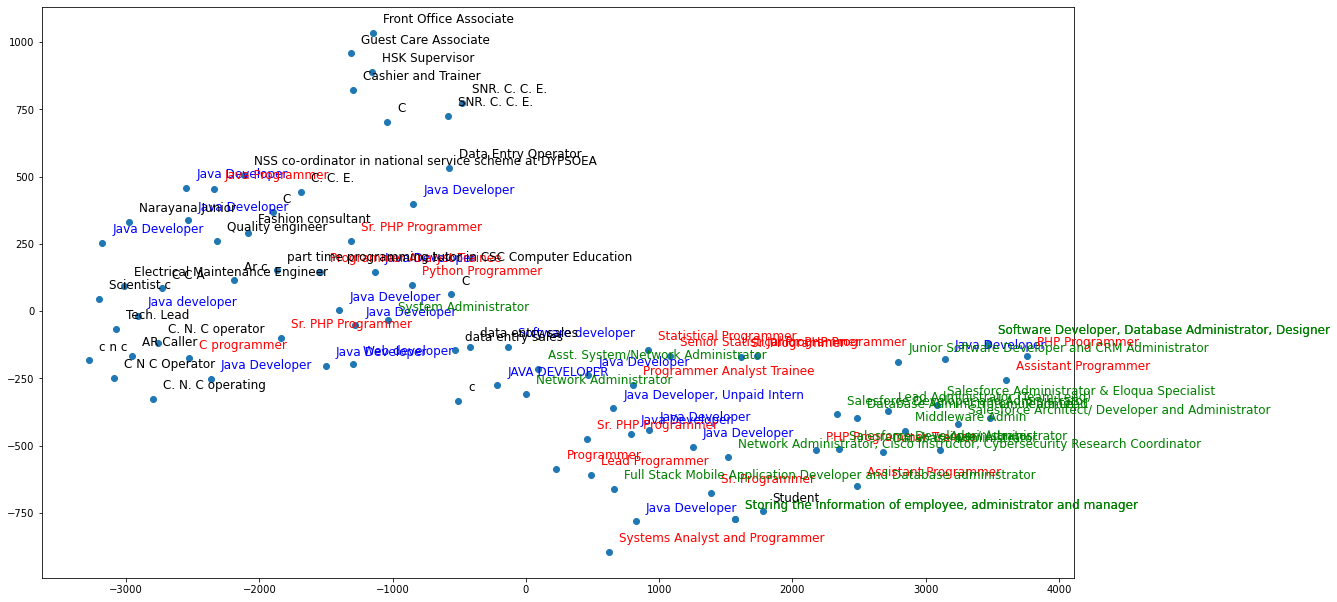

In [10]:
# Here we can still observe that developer and programmer generally go with one another with IT admins on one side
# However we are seeing a far less distinct segmentation for non-IT jobs.
from sklearn.manifold import TSNE
tsne_model_en_2d = TSNE(perplexity=9, n_components=2, init='pca', n_iter=5000, random_state=32)
tsne_out = tsne_model_en_2d.fit_transform(rep_desc_res)
print(tsne_model_en_2d.n_iter)
print(tsne_out[:5])
print(tsne_out.shape)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(tsne_out[:,0], tsne_out[:,1])

for i, txt in enumerate(rep_title_res):
    color = "black"
    color = "red" if "programmer" in txt.lower() else color
    color = "blue" if "developer" in txt.lower() else color
    color = "green" if "admin" in txt.lower() else color
    ax.annotate(txt, tsne_out[i], color=color, xytext=(10,10), textcoords='offset points', fontsize="12")

fig.set_size_inches(18.5, 10.5)

5000
[[1028.5227   -454.67938 ]
 [ 185.83037  -172.19124 ]
 [ 256.79407  -408.85193 ]
 [ 664.1921   -121.91483 ]
 [2867.0188     29.223288]]
(165, 2)


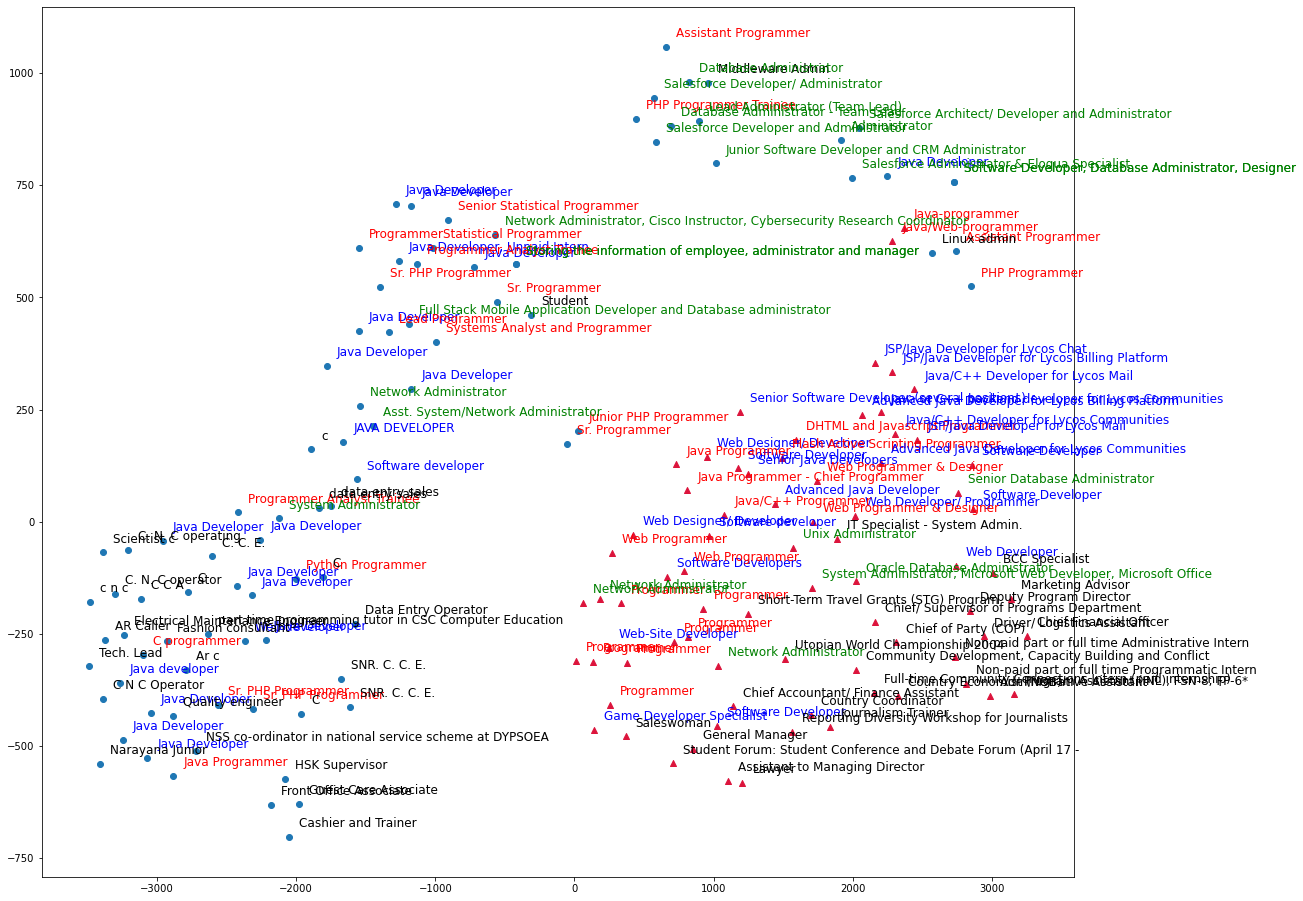

In [11]:
# Here are putting the two graphs together with jobs as circle markers and resumes as triangles. Here we can observe
# that while these two sets are descripting similar job natures, their wording are not exactly similar and thus the
# embeddings are clearly separated into two groups.
# Later in the project illustraions we can see that this would present problems if we use simple cosine similarities
# as our predictor for worthiness for interview of resumes.
from sklearn.manifold import TSNE
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=5000, random_state=32)
tsne_out = tsne_model_en_2d.fit_transform(np.append(rep_desc, rep_desc_res, axis=0))
print(tsne_model_en_2d.n_iter)
print(tsne_out[:5])
print(tsne_out.shape)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(tsne_out[:len(rep_desc),0], tsne_out[:len(rep_desc),1], marker="^", color="crimson")
ax.scatter(tsne_out[len(rep_desc):,0], tsne_out[len(rep_desc):,1], marker="o")

for i, txt in enumerate(rep_title.append(rep_title_res)):
    color = "black"
    color = "red" if "programmer" in txt.lower() else color
    color = "blue" if "developer" in txt.lower() else color
    color = "green" if "administrator" in txt.lower() else color
    ax.annotate(txt, tsne_out[i], color=color, xytext=(10,10), textcoords='offset points', fontsize="12")

fig.set_size_inches(18.5, 16)

In [12]:
# Here we do a similar exercise with LDA. While the countvectorizer is initialized with the full set
# only 1000 records are chosen to allow quick completion of this exploration.
# Here we choose a relatively large n_components in hopes to capture the variety of jobs. As shown below
# only a handle will be considered relevant in the dim-reduced representation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
np.random.seed(seed=42)
all_desc = wdescr_df[~wdescr_df.Type.isna()].iloc[:, 3:5]
shuffled_idxs = np.random.choice(range(len(all_desc)), size=1000,replace=False)

# Parameters
min_df = 1
max_df = 0.9
n_components = 100

cv = CountVectorizer(min_df=min_df, max_df=max_df, stop_words="english")
counts_vecs = cv.fit_transform(all_desc.wdescr)
print(len(cv.vocabulary_))
print(pd.DataFrame(counts_vecs.toarray(), columns=cv.get_feature_names()).shape)
print(pd.DataFrame(counts_vecs.toarray(), columns=cv.get_feature_names()))

lda = LatentDirichletAllocation(n_components=n_components, max_iter=200, evaluate_every=5, random_state=42, verbose=1, n_jobs=-1)
lda_vecs = lda.fit_transform(counts_vecs[shuffled_idxs])

# Other than the perplexity, we also use the lda.score() which is the log likelihood
lda_vecs.shape, lda.n_iter_, lda.bound_, lda.score(counts_vecs[shuffled_idxs])

37805
(19146, 37805)
       00  000  000webhostapp  002  003  005  006  008  009  0091  ...  \
0       0    0              0    0    0    0    0    0    0     0  ...   
1       0    0              0    0    0    0    0    0    0     0  ...   
2       0    0              0    0    0    0    0    0    0     0  ...   
3       0    0              0    0    0    0    0    0    0     0  ...   
4       0    0              0    0    0    0    0    0    0     0  ...   
...    ..  ...            ...  ...  ...  ...  ...  ...  ...   ...  ...   
19141   0    0              0    0    0    0    0    0    0     0  ...   
19142   0    0              0    0    0    0    0    0    0     0  ...   
19143   0    0              0    0    0    0    0    0    0     0  ...   
19144   0    0              0    0    0    0    0    0    0     0  ...   
19145   0    0              0    0    0    0    0    0    0     0  ...   

       øperformance  øprovided  øresponsible  øsuccessfully  øused  øworked  \
0          

iteration: 165 of max_iter: 200, perplexity: 5081.9470


((1000, 100), 164, 5081.946982596521, -576622.2652526058)

Here are the results when LDA is fit with the full set<br>
iteration: 64 of max_iter: 200<br>
iteration: 65 of max_iter: 200, perplexity: 1894.4142<br>
((19146, 100), 64, 1894.4142283809701, -10115240.292981818)

In [13]:
# copied from lecture 2 notebook
def display_components(model, word_features, top_display=5):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print("Topic %d: %s" % (topic_idx, " ".join(top_words)))

In [14]:
display_components(lda, cv.get_feature_names(), top_display=10)

Topic 0: jindal steel power applications pass gate java type spring mvc
Topic 1: data using file learning android problem time query agreement files
Topic 2: data using sql project business created worked tables developed analysis
Topic 3: transactions program training sending declined successful maintaining machinelearning 75 acadview
Topic 4: beagleboard project android xm driver line food worked kernel 1271
Topic 5: knowledge module file features multiple code project edms numbers optimization
Topic 6: data database reporting restful panacim new sql develop test stage
Topic 7: windows india implementation solution domain installation process pvt based developed
Topic 8: js cart landing develop user datastage healthcare kingdom bugs end
Topic 9: erp module management develop description maintain completed based details features
Topic 10: care app social oompfh health networking description solutions website apps
Topic 11: end day running requirements query tunning date client long us

In [15]:
# Here we show those topics most relevant with the record, compared with the original text
pd.options.display.max_colwidth = None
record = 1

def display_most_relevant_topics(corpus, model, vecs, word_features, record_no, top_words=10, shuffled_idxs=shuffled_idxs):
    print(corpus.iloc[shuffled_idxs[record_no]])
    topics = pd.Series(vecs[record_no], index=range(vecs.shape[1])).sort_values(ascending=False)
    print("\nTopics with significance:")
    for topic, val in topics[topics > 0.0002].iteritems():
        print(f'Topic {topic}({round(val,4)}): {" ".join([word_features[i] for i in model.components_[topic].argsort()[::-1][:top_words]])}')

display_most_relevant_topics(all_desc, lda, lda_vecs, cv.get_feature_names(), record)
        
pd.reset_option("display.max_colwidth")

wtitle                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [16]:
# Here we use the same set of resumes we picked before, and plot it in the graph
counts_vecs_select = cv.transform(select_res.wdescr)
lda_vecs_select = lda.transform(counts_vecs_select)
lda_vecs_select.shape

(90, 100)

5000
[[-476.73395   137.30466 ]
 [-444.50867    75.072464]
 [-129.89113  1013.32916 ]
 [ 746.03625   554.35535 ]
 [ 746.03625   554.35535 ]]
(90, 2)


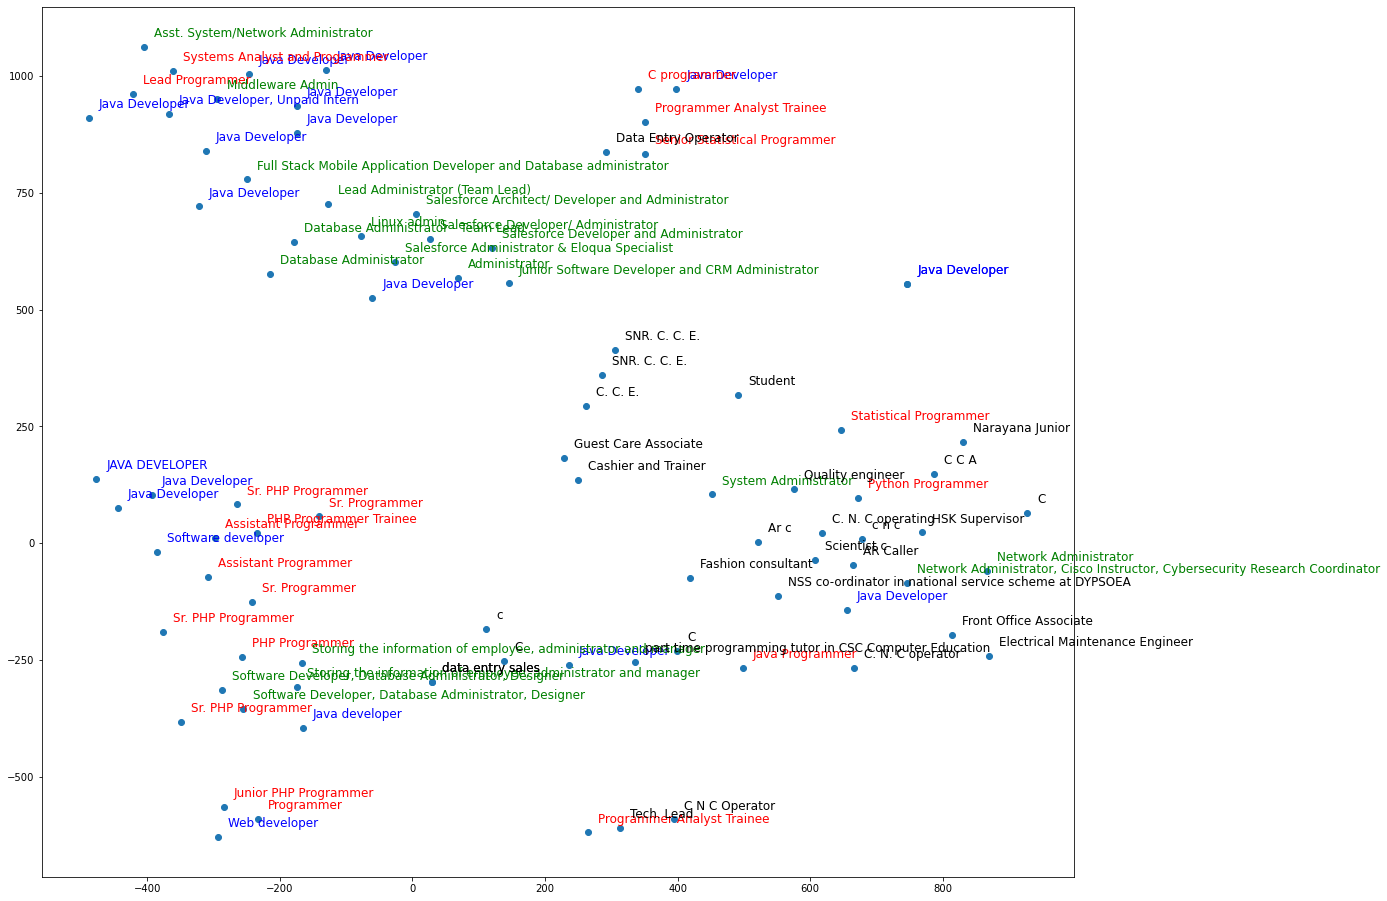

In [17]:
# Here we can see that, while the developers and programmers still group together, with the IT admins grouped aside,
# the distinction is far less clear cut. The non-IT jobs are spread across different types
from sklearn.manifold import TSNE
tsne_model_en_2d = TSNE(perplexity=7, n_components=2, init='pca', n_iter=5000, random_state=32)
tsne_out = tsne_model_en_2d.fit_transform(lda_vecs_select)
print(tsne_model_en_2d.n_iter)
print(tsne_out[:5])
print(tsne_out.shape)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(tsne_out[:,0], tsne_out[:,1])

for i, txt in enumerate(select_res.wtitle):
    color = "black"
    color = "red" if "programmer" in txt.lower() else color
    color = "blue" if "developer" in txt.lower() else color
    color = "green" if "admin" in txt.lower() else color
    ax.annotate(txt, tsne_out[i], color=color, xytext=(10,10), textcoords='offset points', fontsize="12")

fig.set_size_inches(18.5, 16)

In [18]:
# Here we perform a similar procedure for the job descriptions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
np.random.seed(seed=42)
all_desc_job = armenian_job[armenian_job.IT][["Title", "jobpost"]].dropna()
shuffled_idxs_job = np.random.choice(range(len(all_desc_job)), size=1000,replace=False)

# Parameters
min_df = 1
max_df = 0.9
n_components = 100

cv_job = CountVectorizer(min_df=min_df, max_df=max_df, stop_words="english")
counts_vecs_job = cv_job.fit_transform(all_desc_job.jobpost)
print(len(cv_job.vocabulary_))
print(pd.DataFrame(counts_vecs_job.toarray(), columns=cv_job.get_feature_names()).shape)
print(pd.DataFrame(counts_vecs_job.toarray(), columns=cv_job.get_feature_names()))

lda_job = LatentDirichletAllocation(n_components=n_components, max_iter=200, evaluate_every=5, random_state=42, verbose=1, n_jobs=-1)
lda_vecs_job = lda_job.fit_transform(counts_vecs_job[shuffled_idxs_job])
lda_vecs_job.shape, lda_job.n_iter_, lda_job.bound_, lda_job.score(counts_vecs_job[shuffled_idxs_job])

11681
(3759, 11681)
      00  000  0001  0002  00035799  00037711  00049248  00051202  00057507  \
0      1    0     0     0         0         0         0         0         0   
1      1    0     0     0         0         0         0         0         0   
2      0    0     0     0         0         0         0         0         0   
3      0    0     0     0         0         0         0         0         0   
4      0    0     0     0         0         0         0         0         0   
...   ..  ...   ...   ...       ...       ...       ...       ...       ...   
3754   0    0     0     0         0         0         0         0         0   
3755   0    0     0     0         0         0         0         0         0   
3756   0    0     0     0         0         0         0         0         0   
3757   0    0     0     0         0         0         0         0         0   
3758   0    0     0     0         0         0         0         0         0   

      0009  ...  zohrabian  zon

((1000, 100), 124, 1151.6760774150612, -1119306.5209478487)

In [19]:
display_components(lda_job, cv_job.get_feature_names(), top_display=10)

Topic 0: software development services work ability cjsc company developer time team
Topic 1: web candidates cjsc hsbc form programmers work time group april
Topic 2: multi breakfast kitchen stocked parts development tools flexible currently unlimited
Topic 3: credit rural program loan wtm guidelines water lending mca irrigation
Topic 4: data reporting business analysis reports requirements intelligence work analyze develop
Topic 5: web mail programmer studio matit script sites nwslab following xml
Topic 6: lycos europe company java web english development role php european
Topic 7: tools builds source control systems infrastructural manage 2008 information candidates
Topic 8: zvartnots easygoing eastern east easily ease earth early earliest earlier
Topic 9: migrants health 2013 research local iom medical analysis international consultancy
Topic 10: labview national instruments november 00 software open foundation school lesson
Topic 11: tel cell responsible cjsc intake payments operat

In [20]:
pd.options.display.max_colwidth = None
record = 0

display_most_relevant_topics(all_desc_job, lda_job, lda_vecs_job, cv_job.get_feature_names(), record, shuffled_idxs=shuffled_idxs_job)
        
pd.reset_option("display.max_colwidth")

Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [21]:
counts_vecs_select_job = cv_job.transform(select_job.jobpost)
lda_vecs_select_job = lda_job.transform(counts_vecs_select_job)
lda_vecs_select_job.shape

(75, 100)

5000
[[  80.66081   -13.472679]
 [  36.33593   -65.90476 ]
 [-114.63907   -70.17123 ]
 [-151.15155   -10.476804]
 [ 157.99574    42.573868]]
(75, 2)


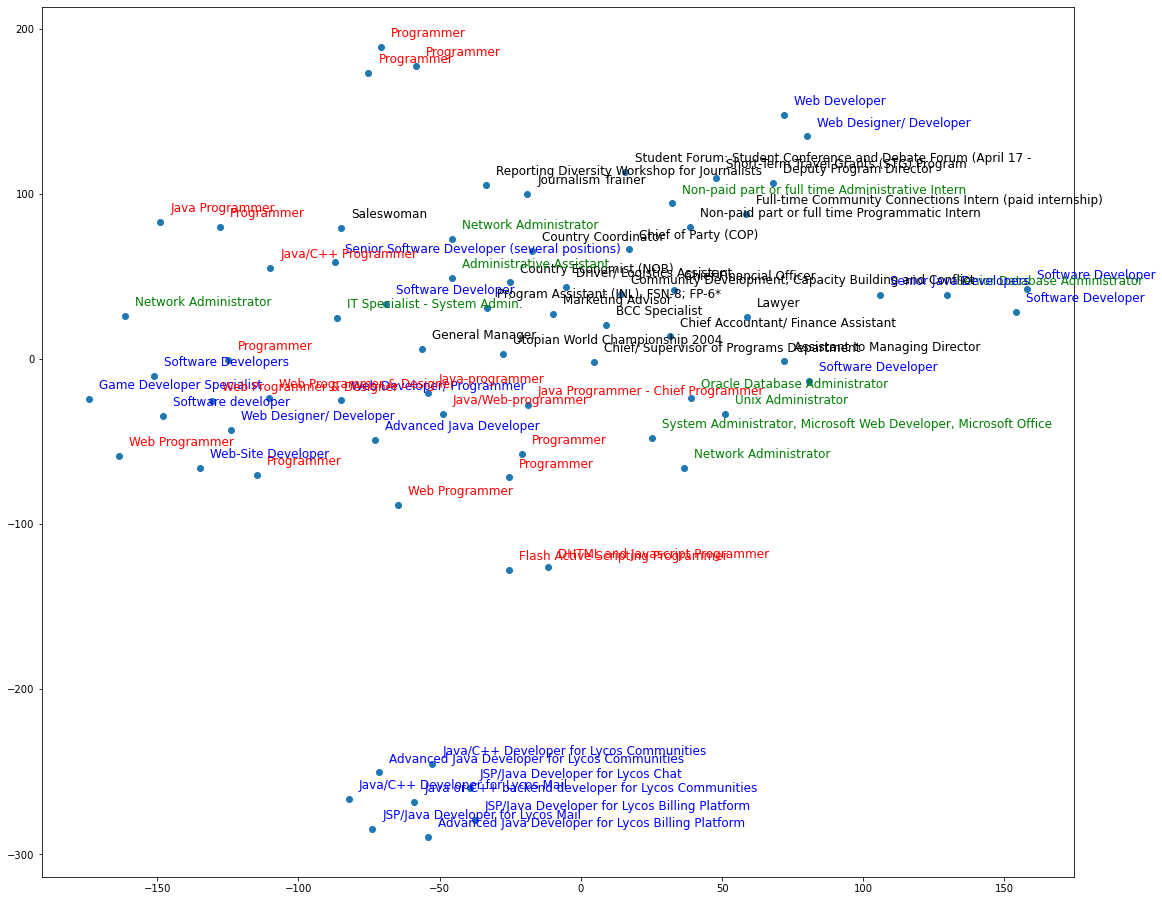

In [22]:
# Again we see a less than clear cut grouping with developers, programmers, IT admins, and non IT jobs
from sklearn.manifold import TSNE
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=5000, random_state=32)
tsne_out = tsne_model_en_2d.fit_transform(lda_vecs_select_job)
print(tsne_model_en_2d.n_iter)
print(tsne_out[:5])
print(tsne_out.shape)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(tsne_out[:,0], tsne_out[:,1])

for i, txt in enumerate(select_job.Title):
    color = "black"
    color = "red" if "programmer" in txt.lower() else color
    color = "blue" if "developer" in txt.lower() else color
    color = "green" if "admin" in txt.lower() else color
    ax.annotate(txt, tsne_out[i], color=color, xytext=(10,10), textcoords='offset points', fontsize="12")

fig.set_size_inches(18.5, 16)